In [1]:
import numpy as np
import xarray as xr
import os
import glob
from pathlib import Path 
import pathlib
from pprint import pprint
import matplotlib.pyplot as plt
import time
import requests
import s3fs
from os.path import dirname, join
import datetime
import myDate
import netCDF4

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings('ignore')

In [2]:
alongtrack_file_dir = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/')
alongtrack_file_dir_randomnoise = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_randomnoise_nosicapplied/')
alongtrack_file_dir_missingdata = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_missingdata_nosicapplied/')
alongtrack_file_dir_orbiterror_2cm = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/')
alongtrack_file_dir_3errors_2cm = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_3errors_2cm_nosicapplied/')

beckley_dailyfile_dir = Path('/home/jpluser/ECCO_GMSL/Data/Beckley_dailyfiles/')

main_dir = Path('/home/jpluser/ECCO_GMSL/')
output_dir = Path('/home/jpluser/ECCO_GMSL/Data/GMSL/')

fig_dir = Path('/home/jpluser/ECCO_GMSL/Figures/')

# Parameters' weight

In [3]:
Vs = 7.2 #satellite along track velocity in km/s
Ve = 0.46 #velocity of earth's rotation at the equator in km/s
incidence = np.deg2rad(66.04) #satellite inclination
sig = 1 #uncertainty
alpha = np.arcsin(np.abs(np.cos(incidence)/np.cos(0)))
gamma = np.arctan(np.abs( (Vs*np.sin(alpha)-Ve*np.cos(0)) / (Vs*np.cos(alpha)) ))
beta0=np.pi/2 - gamma

# Compute Beckley's daily files along track GMSL (Beckley's style)

In [4]:
beckley_alongtrack_dailyfile_dir = list(beckley_dailyfile_dir.glob('MERGED*h5'))
beckley_alongtrack_dailyfile_dir=np.sort(beckley_alongtrack_dailyfile_dir)
beckley_alongtrack_dailyfile_dir

array([], dtype=float64)

In [5]:
#v51
# start_date = np.datetime64('1950-01-01')
# time_fiction=range(myDate.date2jj(1992,9,23),myDate.date2jj(2017,12,31)+11)
# i=2
# lat=[]
# lon=[]
# ssh=[]
# ssh_smoothed=[]
# time=[]
# for j in range(0,10):
#     [year,month,day]=myDate.jj2date(time_fiction[i+j])
#     try:
#         alongtrack_file_cycle=list(beckley_dailyfile_dir.glob('MERGED_ALT-alt_ssh'+str(year)+str(month).zfill(2)+str(day).zfill(2)+'*h5'))[0]
#         print('MERGED_ALT-alt_ssh'+str(year)+str(month).zfill(2)+str(day).zfill(2)+'*h5')
#         ncf = netCDF4.Dataset(alongtrack_file_cycle, diskless=True, persist=False) #v51
#         nch = ncf.groups.get('data')
#         xds = xr.open_dataset(xr.backends.NetCDF4DataStore(nch))
#         lat=np.hstack((lat,xds.latitude))
#         lon=np.hstack((lon,xds.longitude))
#         ssh=np.hstack((ssh,xds.ssh))
#         ssh_smoothed=np.hstack((ssh_smoothed,xds.ssh_smoothed))
#         time=np.hstack((time,xds.time))
#     except:
#         print('no file on: '+str(year)+str(month).zfill(2)+str(day).zfill(2))
# alongtrack = {
#     'ssh': xr.DataArray(ssh_smoothed, dims='time', coords={'time': time}),
#     'lat': xr.DataArray(lat, dims='time', coords={'time': time}),
#     'lon': xr.DataArray(lon, dims='time', coords={'time': time})
# }
# alongtrack = xr.Dataset(alongtrack)
# alongtrack=alongtrack.where((np.abs(alongtrack.lat) <= 66))

In [6]:
time_fiction=range(myDate.date2jj(1992,9,23),myDate.date2jj(2017,12,31)+11)
i=20
ds=[]
for j in range(0,10):
    [year,month,day]=myDate.jj2date(time_fiction[i+j])
    try:
        alongtrack_file_cycle=list(beckley_dailyfile_dir.glob('NASA-SSH_alt_ref_at_v1_'+str(year)+str(month).zfill(2)+str(day).zfill(2)+'*nc'))[0]
        print('NASA-SSH_alt_ref_at_v1_'+str(year)+str(month).zfill(2)+str(day).zfill(2)+'*nc')
        xds = xr.open_dataset(alongtrack_file_cycle)
        xds = xds.drop_vars(['dac','cycle','pass','basin_flag','nasa_flag','source_flag','median_filter_flag','oer','basin_names_table'])
        ds.append(xds)
    except:
        print('no file on: '+str(year)+str(month).zfill(2)+str(day).zfill(2))
alongtrack = xr.concat(ds, dim='time')
alongtrack = alongtrack.rename({'longitude': 'lon','latitude': 'lat'})
alongtrack=alongtrack.where((np.abs(alongtrack.lat) <= 66))

NASA-SSH_alt_ref_at_v1_19921013*nc
NASA-SSH_alt_ref_at_v1_19921014*nc
NASA-SSH_alt_ref_at_v1_19921015*nc
NASA-SSH_alt_ref_at_v1_19921016*nc
NASA-SSH_alt_ref_at_v1_19921017*nc
NASA-SSH_alt_ref_at_v1_19921018*nc
NASA-SSH_alt_ref_at_v1_19921019*nc
NASA-SSH_alt_ref_at_v1_19921020*nc
NASA-SSH_alt_ref_at_v1_19921021*nc
NASA-SSH_alt_ref_at_v1_19921022*nc


In [7]:
alongtrack

<xarray.Dataset> Size: 19MB
Dimensions:       (time: 608503)
Coordinates:
    lat           (time) float32 2MB -9.77 -9.721 -9.672 ... 11.27 11.32 11.42
    lon           (time) float32 2MB 96.39 96.41 96.43 ... 75.66 75.68 75.72
  * time          (time) datetime64[ns] 5MB 1992-10-13 ... 1992-10-22T23:58:10
Data variables:
    ssh           (time) float64 5MB nan nan nan nan nan ... nan nan nan nan nan
    ssh_smoothed  (time) float64 5MB nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/38)
    absolute_offset_applied:   0
    acknowledgement:           This data is provided by NASAs PO.DAAC.
    Conventions:               CF-1.7
    creator_email:             
    creator_name:              NASA-SSH
    creator_url:               https://podaac.jpl.nasa.gov/NASA-SSH/
    ...                        ...
    source_files:              Merged_TOPEX_Jason_OSTM_Jason-3_Sentinel-6_Cyc...
    source_url:                https://podaac.jpl.nasa.gov/dataset/MERGED_TP_...
    summary:                   This data set contains satellite based measure...
    time_coverage_end:         1992-10-13T23:59:59Z
    time_coverage_start:       1992-10-13T00:00:00Z
    title:                     NASA-SSH Along-Track Sea Surface Height from S...

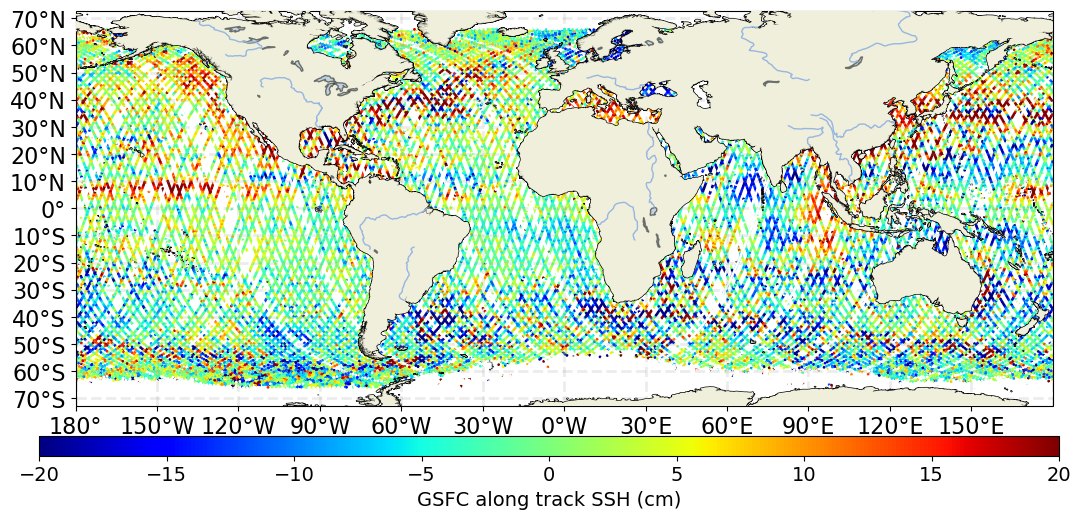

In [8]:
lonmin = -180
lonmax = 180
latmin = -90
latmax = 90
box = [lonmin, lonmax, latmin, latmax]
latstep = 10
lonstep=30
land=True

import cartopy

def init_cartopy_global(projection, box, latstep, lonstep, land, zorder=4,**karg):
    import matplotlib.pyplot as plt
    import numpy
    import cartopy
    import matplotlib.ticker as mticker
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import cartopy.feature as cfeature

    # ax = plt.axes(projection=projection)
    ax=plt.subplot(1,1,1,projection=projection)
    if land==True:
        land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor=cfeature.COLORS['land'])
        ax.add_feature(land_10m, zorder=zorder)
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5, zorder=zorder,edgecolor='black')
    ax.add_feature(cartopy.feature.RIVERS, zorder=zorder)
    ax.coastlines('10m')
    # ax.stock_img()
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.set_xticks(numpy.arange(numpy.floor(box[0]),numpy.floor(box[1]),lonstep), crs=projection)
    ax.set_yticks(numpy.arange(numpy.floor(box[2]),numpy.floor(box[3]),latstep), crs=projection)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(axis='both', which='major', labelsize=16)
    gl = ax.gridlines(draw_labels=False, linestyle='--', linewidth=2, alpha=0.15, color='gray')
    if 'pacific' in karg:
        gl.xlocator = mticker.FixedLocator(numpy.arange(box[1],box[0]+360,lonstep))
    else:
        gl.xlocator = mticker.FixedLocator(numpy.arange(numpy.floor(box[0]),numpy.floor(box[1])+lonstep,lonstep))
    gl.ylocator = mticker.FixedLocator(numpy.arange(numpy.floor(box[2]),numpy.floor(box[3])+latstep,latstep))
    return ax, gl


kk=12

fig = plt.figure(figsize=(15,5))
data_proj = cartopy.crs.PlateCarree(central_longitude=0)
map_proj = cartopy.crs.PlateCarree(central_longitude=0)
ax, gl = init_cartopy_global(map_proj, box, latstep, lonstep, land) 
palette=plt.cm.jet
palette.set_bad('w',1.0)
pp = plt.scatter(alongtrack.lon[::kk],alongtrack.lat[::kk],c=alongtrack.ssh[::kk]*100, s=1,cmap=palette,vmin=-20,vmax=20,transform=data_proj) 
plt.subplots_adjust(right=0.9,left=0.1,top=0.99,bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.68, 0.04])
h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal')
h.set_label('GSFC along track SSH (cm)',fontsize=14)
h.ax.tick_params(labelsize=14)
plt.savefig(fig_dir / 'map_cycle1_beckley.png',dpi=200,transparent=False,facecolor='white')

In [9]:
#v51
# beckley_gmsl_tmp=[]
# time_gmsl=[]

# start_date = np.datetime64('1950-01-01')
# time_fiction=range(myDate.date2jj(1992,9,23),myDate.date2jj(2017,12,31)+11)
# for i in np.arange(0,len(time_fiction)-10,10):
#     lat=[]
#     lon=[]
#     ssh=[]
#     ssh_smoothed=[]
#     time=[]
#     for j in range(0,10):
#         [year,month,day]=myDate.jj2date(time_fiction[i+j])
#         try:
#             alongtrack_file_cycle=list(beckley_dailyfile_dir.glob('MERGED_ALT-alt_ssh'+str(year)+str(month).zfill(2)+str(day).zfill(2)+'*h5'))[0]
#             ncf = netCDF4.Dataset(alongtrack_file_cycle, diskless=True, persist=False)
#             nch = ncf.groups.get('data')
#             xds = xr.open_dataset(xr.backends.NetCDF4DataStore(nch))
#             lat=np.hstack((lat,xds.latitude))
#             lon=np.hstack((lon,xds.longitude))
#             ssh=np.hstack((ssh,xds.ssh))
#             ssh_smoothed=np.hstack((ssh_smoothed,xds.ssh_smoothed))
#             time=np.hstack((time,xds.time))
#         except:
#             print('no file on: '+str(year)+str(month).zfill(2)+str(day).zfill(2))
#     try:
#         alongtrack = {
#             'ssh': xr.DataArray(ssh_smoothed, dims='time', coords={'time': time}),
#             'lat': xr.DataArray(lat, dims='time', coords={'time': time}),
#             'lon': xr.DataArray(lon, dims='time', coords={'time': time})
#         }
#         alongtrack = xr.Dataset(alongtrack)
#         alongtrack=alongtrack.where((np.abs(alongtrack.lat) <= 66))
#         SSH_at_xy_ano=alongtrack.ssh
#         alpha = np.arcsin(np.abs(np.cos(incidence)/np.cos(np.deg2rad(alongtrack.lat))))
#         gamma = np.arctan(np.abs( (Vs*np.sin(alpha)-Ve*np.cos(np.deg2rad(alongtrack.lat))) / (Vs*np.cos(alpha)) ))
#         beta = np.pi/2 - gamma
#         w=np.sin(beta)/np.sin(beta0) #From Nerem 1995
#         w=w.where(np.isfinite(SSH_at_xy_ano))
#         time_gmsl = np.hstack((time_gmsl,time_fiction[i]))
#         beckley_gmsl_tmp.append((SSH_at_xy_ano*w).sum(skipna=True)/w.sum(skipna=True))
#     except:
#         time_gmsl = np.hstack((time_gmsl,time_fiction[i]))
#         beckley_gmsl_tmp.append(np.nan)

# beckley_gmsl = xr.concat(beckley_gmsl_tmp, dim='time')
# beckley_gmsl

In [10]:
time_gmsl=[]
beckley_gmsl_tmp=[]
time_fiction=range(myDate.date2jj(1992,9,23),myDate.date2jj(2017,12,31)+11)
for i in np.arange(0,len(time_fiction)-10,10):
    ds=[]
    alongtrack=[]
    for j in range(0,10):
        [year,month,day]=myDate.jj2date(time_fiction[i+j])
        try:
            alongtrack_file_cycle=list(beckley_dailyfile_dir.glob('NASA-SSH_alt_ref_at_v1_'+str(year)+str(month).zfill(2)+str(day).zfill(2)+'*nc'))[0]
            xds = xr.open_dataset(alongtrack_file_cycle)
            xds = xds.drop_vars(['dac','cycle','pass','basin_flag','nasa_flag','source_flag','median_filter_flag','oer','basin_names_table'])
            ds.append(xds)
        except:
            print('no file on: '+str(year)+str(month).zfill(2)+str(day).zfill(2))
    try:
        alongtrack = xr.concat(ds, dim='time')
        alongtrack = alongtrack.rename({'longitude': 'lon','latitude': 'lat'})
        alongtrack=alongtrack.where((np.abs(alongtrack.lat) <= 66))
        SSH_at_xy_ano=alongtrack.ssh_smoothed
        alpha = np.arcsin(np.abs(np.cos(incidence)/np.cos(np.deg2rad(alongtrack.lat))))
        gamma = np.arctan(np.abs( (Vs*np.sin(alpha)-Ve*np.cos(np.deg2rad(alongtrack.lat))) / (Vs*np.cos(alpha)) ))
        beta = np.pi/2 - gamma
        w=np.sin(beta)/np.sin(beta0) #From Nerem 1995
        w=w.where(np.isfinite(SSH_at_xy_ano))
        time_gmsl = np.hstack((time_gmsl,time_fiction[i]))
        beckley_gmsl_tmp.append((SSH_at_xy_ano*w).sum(skipna=True)/w.sum(skipna=True))
    except:
        print('empty cycle on: '+str(year)+str(month).zfill(2)+str(day).zfill(2))

beckley_gmsl = xr.concat(beckley_gmsl_tmp, dim='time')

no file on: 19920923
no file on: 19920924
no file on: 19920925
no file on: 19920926
no file on: 19920927
no file on: 19920928
no file on: 19920929
no file on: 19920930
no file on: 19921001
no file on: 19921002
empty cycle on: 19921002
no file on: 19921003
no file on: 19921004
no file on: 19921005
no file on: 19921006
no file on: 19921007
no file on: 19921008
no file on: 19921009
no file on: 19921010
no file on: 19921011
no file on: 19921012
empty cycle on: 19921012
empty cycle on: 20031204
empty cycle on: 20051004
empty cycle on: 20061118
no file on: 20180101
no file on: 20180102
no file on: 20180103
no file on: 20180104
no file on: 20180105
no file on: 20180106
no file on: 20180107
no file on: 20180108
no file on: 20180109


In [11]:
start_date = np.datetime64('1950-01-01')
beckley_gmsl.name = 'gmsl_beckley_daily_alongtrack'
beckley_gmsl.attrs['units'] = 'm'
beckley_gmsl.attrs['summary'] = '10-day GMSL time series computed on the daily file alongtrack GSFC data'#, referenced to a 1996-2016 global mean SSH'
beckley_gmsl.time.attrs['long_name'] = 'mid day of the 10-day average'
beckley_gmsl['time']= start_date + np.timedelta64(1, 'D') * (time_gmsl+4) 
beckley_gmsl

<xarray.DataArray 'gmsl_beckley_daily_alongtrack' (time: 919)> Size: 7kB
array([-1.06802075e-03, -2.00347548e-03, -3.44442184e-03, -4.58537972e-03,
       -4.02212570e-03, -6.82830446e-03, -1.32099188e-02, -1.45408054e-02,
       -1.63498040e-02, -1.80950395e-02, -2.07604321e-02, -2.08195907e-02,
       -1.83735660e-02, -1.64245923e-02, -1.54025530e-02, -1.60992100e-02,
       -1.85816086e-02, -1.98266907e-02, -1.97681564e-02, -1.89269682e-02,
       -2.05015214e-02, -2.17108916e-02, -2.22653781e-02, -2.20869323e-02,
       -1.93598128e-02, -1.58518835e-02, -1.68474172e-02, -1.65243482e-02,
       -1.84695759e-02, -1.71605005e-02, -1.41971860e-02, -1.03143226e-02,
       -9.63049136e-03, -1.02293497e-02, -9.57670244e-03, -8.57349184e-03,
       -5.92232434e-03, -5.99211200e-03, -7.18970100e-03, -9.71729740e-03,
       -1.10178947e-02, -1.03670469e-02, -7.61282848e-03, -6.34676674e-03,
       -9.21857613e-03, -1.22768192e-02, -1.11641822e-02, -1.18647119e-02,
       -1.41959487e-02, -1.52664924e-02, -1.30247205e-02, -1.16147411e-02,
       -1.20742900e-02, -1.36208538e-02, -1.39234725e-02, -1.43462138e-02,
       -1.67253835e-02, -1.83769335e-02, -1.92845872e-02, -1.75820565e-02,
       -1.61921266e-02, -1.63648152e-02, -1.77592138e-02, -1.67585779e-02,
       -1.51072368e-02, -1.32915925e-02, -9.87729961e-03, -8.12366243e-03,
       -7.12783280e-03, -5.99233279e-03, -5.92724863e-03, -4.30665997e-03,
       -2.87325332e-03, -1.20825397e-03, -1.78831618e-03, -3.44465370e-03,
       -5.02886345e-03, -6.04101619e-03, -5.23845769e-03, -2.50844000e-03,
...
        5.98598095e-02,  5.98105546e-02,  5.92118842e-02,  5.85590809e-02,
        5.48956727e-02,  5.41828048e-02,  5.74446811e-02,  5.73939213e-02,
        5.72968381e-02,  5.64678438e-02,  5.54046640e-02,  5.37478738e-02,
        5.21562330e-02,  5.20806100e-02,  5.07647635e-02,  4.96081832e-02,
        4.90821007e-02,  4.76018674e-02,  4.62235303e-02,  4.60528751e-02,
        4.74176143e-02,  4.88591115e-02,  4.96637733e-02,  5.02235343e-02,
        5.02112977e-02,  5.02096634e-02,  5.06816842e-02,  5.12928765e-02,
        5.33644338e-02,  5.78138615e-02,  5.88860275e-02,  5.94748566e-02,
        5.79952569e-02,  5.88305668e-02,  6.13390571e-02,  6.09154773e-02,
        6.07650600e-02,  6.29327914e-02,  6.13091640e-02,  5.93392975e-02,
        5.75081713e-02,  5.56165113e-02,  5.51303891e-02,  5.47767458e-02,
        5.24004275e-02,  5.07972492e-02,  5.10970271e-02,  5.16422173e-02,
        5.13303479e-02,  5.02594413e-02,  5.04597258e-02,  5.02136796e-02,
        4.87099238e-02,  4.68440737e-02,  4.58475905e-02,  4.52858239e-02,
        4.55294645e-02,  4.65815329e-02,  4.87814973e-02,  4.87882389e-02,
        4.82379560e-02,  5.07297836e-02,  5.32203074e-02,  5.59969753e-02,
        5.66773349e-02,  5.76024822e-02,  6.05625842e-02,  6.23072500e-02,
        6.10150076e-02,  6.10626613e-02,  6.20672754e-02,  6.29156311e-02,
        6.36162083e-02,  6.44521726e-02,  6.35796057e-02,  6.32550021e-02,
        6.21923259e-02,  5.98825808e-02,  5.88558302e-02])
Coordinates:
  * time     (time) datetime64[ns] 7kB 1992-10-17 1992-10-27 ... 2018-01-04
Attributes:
    units:    m
    summary:  10-day GMSL time series computed on the daily file alongtrack G...

In [12]:
fname = output_dir / ('GMSL_Beckley_dailyfiles_otherweight.nc')
beckley_gmsl.to_netcdf(fname)

# Compute ECCO along track GMSL with simple weights

### No error
#### Compute the reference global mean SSH over 20 years 1996-2016

In [10]:
# ECCO_alongtrack_files=[]
# for year in range(1996,2017):
#     ECCO_alongtrack_files_tmp = list(alongtrack_file_dir.glob('*ECCO_V4r4_alongtrack_SSH_*'+str(year)+'*nc'))
#     ECCO_alongtrack_files.extend(ECCO_alongtrack_files_tmp)
# print(np.sort(ECCO_alongtrack_files))

In [11]:
# alongtrack = xr.open_mfdataset(
#         paths=ECCO_alongtrack_files,
#         combine='nested',
#         concat_dim='i',
#         decode_cf=True,
#         compat='override',
#         coords='minimal',
#         chunks={'time': 1}  
#     )  
# alongtrack

In [12]:
# ref_mean=alongtrack.SSH_at_xy.mean(skipna=True).values
# print(ref_mean)

#### Compute GMSL 10-day time series

In [13]:
ECCO_alongtrack_files = list(alongtrack_file_dir.glob('*ECCO_V4r4_alongtrack_SSH*nc'))
ECCO_alongtrack_files=np.sort(ECCO_alongtrack_files)
# print(ECCO_alongtrack_files)

In [14]:
alongtrack_gmsl_tmp=[]
for i in np.arange(0,len(ECCO_alongtrack_files),10):
    ECCO_alongtrack_files_cycle=ECCO_alongtrack_files[i:i+10]
    alongtrack = xr.open_mfdataset(
            paths=ECCO_alongtrack_files_cycle,
            combine='nested',
            concat_dim='i',
            decode_cf=True,
            compat='override',
            coords='minimal',
            chunks={'time': 1}  
        )  
    alongtrack=alongtrack.where((np.abs(alongtrack.lat) <= 66))
    SSH_at_xy_ano=alongtrack.SSH_at_xy
    # SSH_at_xy_ano=alongtrack.SSH_at_xy-ref_mean
    alpha = np.arcsin(np.abs(np.cos(incidence)/np.cos(np.deg2rad(alongtrack.lat))))
    gamma = np.arctan(np.abs( (Vs*np.sin(alpha)-Ve*np.cos(np.deg2rad(alongtrack.lat))) / (Vs*np.cos(alpha)) ))
    beta = np.pi/2 - gamma
    w=np.sin(beta)/np.sin(beta0) #From Nerem 1995
    w=w.where(np.isfinite(SSH_at_xy_ano))
    alongtrack_gmsl_tmp.append((SSH_at_xy_ano*w).sum(skipna=True)/w.sum(skipna=True))
    
    # fig = plt.figure(figsize=(15,5))
    # cm = plt.get_cmap('gist_rainbow')
    # ax=fig.gca()
    # ax = plt.axes(projection=ccrs.Robinson( \
    #               central_longitude=-67, globe=None))
    # ax.gridlines()
    # ax.add_feature(cfeature.LAND)
    # ax.add_feature(cfeature.COASTLINE)
    # kk=12
    # p=ax.scatter(alongtrack.lon[::kk],\
    #                      alongtrack.lat[::kk], \
    #                      c=(SSH_at_xy_ano*w)[::kk], s=1,\
    #                      transform=ccrs.PlateCarree(),
    #                      vmin=-1,vmax=1, cmap='jet')
alongtrack_gmsl = xr.concat(alongtrack_gmsl_tmp, dim='time')

In [15]:
SSH_at_xy_ano

<xarray.DataArray 'SSH_at_xy' (i: 59523)> Size: 238kB
dask.array<where, shape=(59523,), dtype=float32, chunksize=(59523,), chunktype=numpy.ndarray>
Coordinates:
    time        datetime64[ns] 8B 2017-12-31
    cycle_day   int64 8B 0
    cycle       int64 8B 924
    delta_days  int64 8B 9230
    lon         (i) float32 238kB dask.array<chunksize=(59523,), meta=np.ndarray>
    lat         (i) float32 238kB dask.array<chunksize=(59523,), meta=np.ndarray>
Dimensions without coordinates: i
Attributes:
    source:   ECCO V4r4

In [16]:
alongtrack_gmsl=alongtrack_gmsl.drop('cycle_day')
alongtrack_gmsl=alongtrack_gmsl.drop('delta_days')
alongtrack_gmsl.name = 'gmsl_ecco_alongtrack'
alongtrack_gmsl.attrs['units'] = 'm'
alongtrack_gmsl.attrs['summary'] = '10-day GMSL time series computed on the alongtrack ECCO data'#, referenced to a 1996-2016 global mean SSH'
alongtrack_gmsl.time.attrs['long_name'] = 'mid day of the 10-day average'
alongtrack_gmsl['time']=alongtrack_gmsl.time+(4*24*60*60*10**(9))
alongtrack_gmsl

<xarray.DataArray 'gmsl_ecco_alongtrack' (time: 924)> Size: 4kB
dask.array<concatenate, shape=(924,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    cycle    (time) int64 7kB 1 2 3 4 5 6 7 8 ... 918 919 920 921 922 923 924
  * time     (time) datetime64[ns] 7kB 1992-09-27 1992-10-07 ... 2018-01-04
Attributes:
    units:    m
    summary:  10-day GMSL time series computed on the alongtrack ECCO data

In [17]:
fname = output_dir / ('GMSL_ECCO_alongtrack_19922017_noerror_otherweight_nomean_nosicapplied.nc')
alongtrack_gmsl.to_netcdf(fname)

### Random noise error
#### Compute the reference global mean SSH over 20 years 1996-2016

In [18]:
# ECCO_alongtrack_files=[]
# for year in range(1996,2017):
#     ECCO_alongtrack_files_tmp = list(alongtrack_file_dir_randomnoise.glob('*ECCO_V4r4_alongtrack_SSH_*'+str(year)+'*nc'))
#     ECCO_alongtrack_files.extend(ECCO_alongtrack_files_tmp)
# print(np.sort(ECCO_alongtrack_files))

In [19]:
# alongtrack = xr.open_mfdataset(
#         paths=ECCO_alongtrack_files,
#         combine='nested',
#         concat_dim='i',
#         decode_cf=True,
#         compat='override',
#         coords='minimal',
#         chunks={'time': 1}  
#     )  
# alongtrack

In [20]:
# ref_mean_randomnoise=alongtrack.SSH_at_xy.mean(skipna=True).values
# print(ref_mean_randomnoise)

#### Compute GMSL 10-day time series

In [21]:
ECCO_alongtrack_files = list(alongtrack_file_dir_randomnoise.glob('*ECCO_V4r4_alongtrack_SSH_*nc'))
ECCO_alongtrack_files=np.sort(ECCO_alongtrack_files)
print(ECCO_alongtrack_files)

[PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_randomnoise_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-23_randomnoise.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_randomnoise_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-24_randomnoise.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_randomnoise_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-25_randomnoise.nc')
 ...
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_randomnoise_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-29_randomnoise.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_randomnoise_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-30_randomnoise.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_randomnoise_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-31_randomnoise.nc')]


In [22]:
alongtrack_gmsl_tmp=[]
for i in np.arange(0,len(ECCO_alongtrack_files),10):
    ECCO_alongtrack_files_cycle=ECCO_alongtrack_files[i:i+10]
    alongtrack = xr.open_mfdataset(
            paths=ECCO_alongtrack_files_cycle,
            combine='nested',
            concat_dim='i',
            decode_cf=True,
            compat='override',
            coords='minimal',
            chunks={'time': 1}  
        )  
    alongtrack=alongtrack.where((np.abs(alongtrack.lat) <= 66))
    SSH_at_xy_ano=alongtrack.SSH_at_xy
    # SSH_at_xy_ano=alongtrack.SSH_at_xy-ref_mean
    alpha = np.arcsin(np.abs(np.cos(incidence)/np.cos(np.deg2rad(alongtrack.lat))))
    gamma = np.arctan(np.abs( (Vs*np.sin(alpha)-Ve*np.cos(np.deg2rad(alongtrack.lat))) / (Vs*np.cos(alpha)) ))
    beta = np.pi/2 - gamma
    w=np.sin(beta)/np.sin(beta0) #From Nerem 1995
    w=w.where(np.isfinite(SSH_at_xy_ano))
    alongtrack_gmsl_tmp.append((SSH_at_xy_ano*w).sum(skipna=True)/w.sum(skipna=True))
alongtrack_gmsl_randomnoise = xr.concat(alongtrack_gmsl_tmp, dim='time')

In [23]:
alongtrack_gmsl_randomnoise=alongtrack_gmsl_randomnoise.drop('cycle_day')
alongtrack_gmsl_randomnoise=alongtrack_gmsl_randomnoise.drop('delta_days')
alongtrack_gmsl_randomnoise.name = 'gmsl_ecco_alongtrack'
alongtrack_gmsl_randomnoise.attrs['units'] = 'm'
alongtrack_gmsl_randomnoise.attrs['summary'] = '10-day GMSL time series computed on the alongtrack ECCO data with random noise'#, referenced to a 1996-2016 global mean SSH'
alongtrack_gmsl_randomnoise.time.attrs['long_name'] = 'first day of the 10-day average'
alongtrack_gmsl_randomnoise['time']=alongtrack_gmsl_randomnoise.time+(4*24*60*60*10**(9))
alongtrack_gmsl_randomnoise

<xarray.DataArray 'gmsl_ecco_alongtrack' (time: 924)> Size: 7kB
dask.array<concatenate, shape=(924,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    cycle    (time) int64 7kB 1 2 3 4 5 6 7 8 ... 918 919 920 921 922 923 924
  * time     (time) datetime64[ns] 7kB 1992-09-27 1992-10-07 ... 2018-01-04
Attributes:
    units:    m
    summary:  10-day GMSL time series computed on the alongtrack ECCO data wi...

In [24]:
fname = output_dir / ('GMSL_ECCO_alongtrack_19922017_randomnoise_otherweight_nomean_nosicapplied.nc')
alongtrack_gmsl_randomnoise.to_netcdf(fname)

### Missing data
#### Compute the reference global mean SSH over 20 years 1996-2016

In [25]:
# ECCO_alongtrack_files=[]
# for year in range(1996,2017):
#     ECCO_alongtrack_files_tmp = list(alongtrack_file_dir_missingdata.glob('*ECCO_V4r4_alongtrack_SSH_*'+str(year)+'*nc'))
#     ECCO_alongtrack_files.extend(ECCO_alongtrack_files_tmp)
# print(np.sort(ECCO_alongtrack_files))

In [26]:
# alongtrack = xr.open_mfdataset(
#         paths=ECCO_alongtrack_files,
#         combine='nested',
#         concat_dim='i',
#         decode_cf=True,
#         compat='override',
#         coords='minimal',
#         chunks={'time': 1}  
#     )  
# alongtrack

In [27]:
# ref_mean_missingdata=alongtrack.SSH_at_xy.mean(skipna=True).values
# print(ref_mean_missingdata)

#### Compute GMSL 10-day time series

In [28]:
ECCO_alongtrack_files = list(alongtrack_file_dir_missingdata.glob('*ECCO_V4r4_alongtrack_SSH*nc'))
ECCO_alongtrack_files=np.sort(ECCO_alongtrack_files)
# print(ECCO_alongtrack_files)

In [29]:
alongtrack_gmsl_tmp_missingdata=[]
ind_vec=[]
for i in np.arange(0,len(ECCO_alongtrack_files),10):
    ECCO_alongtrack_files_cycle=ECCO_alongtrack_files[i:i+10]
    alongtrack = xr.open_mfdataset(
            paths=ECCO_alongtrack_files_cycle,
            combine='nested',
            concat_dim='i',
            decode_cf=True,
            compat='override',
            coords='minimal',
            chunks={'time': 1}  
        )  
    alongtrack=alongtrack.where((np.abs(alongtrack.lat) <= 66))
    SSH_at_xy_ano_missingdata=alongtrack.SSH_at_xy
    # SSH_at_xy_ano=alongtrack.SSH_at_xy-ref_mean
    alpha = np.arcsin(np.abs(np.cos(incidence)/np.cos(np.deg2rad(alongtrack.lat))))
    gamma = np.arctan(np.abs( (Vs*np.sin(alpha)-Ve*np.cos(np.deg2rad(alongtrack.lat))) / (Vs*np.cos(alpha)) ))
    beta = np.pi/2 - gamma
    w=np.sin(beta)/np.sin(beta0) #From Nerem 1995
    w=w.where(np.isfinite(SSH_at_xy_ano_missingdata))
    alongtrack_gmsl_tmp_missingdata.append((SSH_at_xy_ano_missingdata*w).sum(skipna=True)/w.sum(skipna=True))
alongtrack_gmsl_missingdata = xr.concat(alongtrack_gmsl_tmp_missingdata, dim='time')

In [30]:
alongtrack_gmsl_missingdata=alongtrack_gmsl_missingdata.drop('cycle_day')
alongtrack_gmsl_missingdata=alongtrack_gmsl_missingdata.drop('delta_days')
alongtrack_gmsl_missingdata.name = 'gmsl_ecco_alongtrack'
alongtrack_gmsl_missingdata.attrs['units'] = 'm'
alongtrack_gmsl_missingdata.attrs['summary'] = '10-day GMSL time series computed on the alongtrack ECCO data with missing data'#, referenced to a 1996-2016 global mean SSH'
alongtrack_gmsl_missingdata.time.attrs['long_name'] = 'first day of the 10-day average'
alongtrack_gmsl_missingdata['time']=alongtrack_gmsl_missingdata.time+(4*24*60*60*10**(9))
alongtrack_gmsl_missingdata

<xarray.DataArray 'gmsl_ecco_alongtrack' (time: 924)> Size: 4kB
dask.array<concatenate, shape=(924,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    cycle    (time) int64 7kB 1 2 3 4 5 6 7 8 ... 918 919 920 921 922 923 924
  * time     (time) datetime64[ns] 7kB 1992-09-27 1992-10-07 ... 2018-01-04
Attributes:
    units:    m
    summary:  10-day GMSL time series computed on the alongtrack ECCO data wi...

In [31]:
fname = output_dir / ('GMSL_ECCO_alongtrack_19922017_missingdata_otherweight_nomean_nosicapplied.nc')
alongtrack_gmsl_missingdata.to_netcdf(fname)

### Orbit error - 2cm
#### Compute the reference global mean SSH over 20 years 1996-2016

#### Compute GMSL 10-day time series

In [32]:
ECCO_alongtrack_files = list(alongtrack_file_dir_orbiterror_2cm.glob('*ECCO_V4r4_alongtrack_SSH_*nc'))
ECCO_alongtrack_files=np.sort(ECCO_alongtrack_files)
print(ECCO_alongtrack_files)

[PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-23_orbiterror.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-24_orbiterror.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-25_orbiterror.nc')
 ...
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-29_orbiterror.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-30_orbiterror.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-31_orbiterror.nc')]


In [33]:
alongtrack_gmsl_tmp=[]
for i in np.arange(0,len(ECCO_alongtrack_files),10):
    ECCO_alongtrack_files_cycle=ECCO_alongtrack_files[i:i+10]
    alongtrack = xr.open_mfdataset(
            paths=ECCO_alongtrack_files_cycle,
            combine='nested',
            concat_dim='i',
            decode_cf=True,
            compat='override',
            coords='minimal',
            chunks={'time': 1}  
        )  
    alongtrack=alongtrack.where((np.abs(alongtrack.lat) <= 66))
    SSH_at_xy_ano=alongtrack.SSH_at_xy
    # SSH_at_xy_ano=alongtrack.SSH_at_xy-ref_mean
    alpha = np.arcsin(np.abs(np.cos(incidence)/np.cos(np.deg2rad(alongtrack.lat))))
    gamma = np.arctan(np.abs( (Vs*np.sin(alpha)-Ve*np.cos(np.deg2rad(alongtrack.lat))) / (Vs*np.cos(alpha)) ))
    beta = np.pi/2 - gamma
    w=np.sin(beta)/np.sin(beta0) #From Nerem 1995
    w=w.where(np.isfinite(SSH_at_xy_ano))
    alongtrack_gmsl_tmp.append((SSH_at_xy_ano*w).sum(skipna=True)/w.sum(skipna=True))
alongtrack_gmsl_orbiterror_2cm = xr.concat(alongtrack_gmsl_tmp, dim='time')

In [34]:
alongtrack_gmsl_orbiterror_2cm=alongtrack_gmsl_orbiterror_2cm.drop('cycle_day')
alongtrack_gmsl_orbiterror_2cm=alongtrack_gmsl_orbiterror_2cm.drop('delta_days')
alongtrack_gmsl_orbiterror_2cm.name = 'gmsl_ecco_alongtrack'
alongtrack_gmsl_orbiterror_2cm.attrs['units'] = 'm'
alongtrack_gmsl_orbiterror_2cm.attrs['summary'] = '10-day GMSL time series computed on the alongtrack ECCO data with 2cm orbit error'#, referenced to a 1996-2016 global mean SSH'
alongtrack_gmsl_orbiterror_2cm.time.attrs['long_name'] = 'first day of the 10-day average'
alongtrack_gmsl_orbiterror_2cm['time']=alongtrack_gmsl_orbiterror_2cm.time+(4*24*60*60*10**(9))
alongtrack_gmsl_orbiterror_2cm

<xarray.DataArray 'gmsl_ecco_alongtrack' (time: 924)> Size: 7kB
dask.array<concatenate, shape=(924,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    cycle    (time) int64 7kB 1 2 3 4 5 6 7 8 ... 918 919 920 921 922 923 924
  * time     (time) datetime64[ns] 7kB 1992-09-27 1992-10-07 ... 2018-01-04
Attributes:
    units:    m
    summary:  10-day GMSL time series computed on the alongtrack ECCO data wi...

In [35]:
fname = output_dir / ('GMSL_ECCO_alongtrack_19922017_orbiterror_2cm_otherweight_nomean_nosicapplied.nc')
alongtrack_gmsl_orbiterror_2cm.to_netcdf(fname)

### 3 errors: Random noise + missing data + orbit error - 2cm
#### Compute the reference global mean SSH over 20 years 1996-2016

#### Compute GMSL 10-day time series

In [36]:
ECCO_alongtrack_files = list(alongtrack_file_dir_3errors_2cm.glob('*ECCO_V4r4_alongtrack_SSH_*nc'))
ECCO_alongtrack_files=np.sort(ECCO_alongtrack_files)
print(ECCO_alongtrack_files)

[PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_3errors_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-23_3errors.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_3errors_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-24_3errors.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_3errors_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-25_3errors.nc')
 ...
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_3errors_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-29_3errors.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_3errors_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-30_3errors.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_3errors_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-31_3errors.nc')]


In [37]:
alongtrack_gmsl_tmp=[]
for i in np.arange(0,len(ECCO_alongtrack_files),10):
    ECCO_alongtrack_files_cycle=ECCO_alongtrack_files[i:i+10]
    alongtrack = xr.open_mfdataset(
            paths=ECCO_alongtrack_files_cycle,
            combine='nested',
            concat_dim='i',
            decode_cf=True,
            compat='override',
            coords='minimal',
            chunks={'time': 1}  
        )  
    alongtrack=alongtrack.where((np.abs(alongtrack.lat) <= 66))
    SSH_at_xy_ano=alongtrack.SSH_at_xy
    # SSH_at_xy_ano=alongtrack.SSH_at_xy-ref_mean    
    alpha = np.arcsin(np.abs(np.cos(incidence)/np.cos(np.deg2rad(alongtrack.lat))))
    gamma = np.arctan(np.abs( (Vs*np.sin(alpha)-Ve*np.cos(np.deg2rad(alongtrack.lat))) / (Vs*np.cos(alpha)) ))
    beta = np.pi/2 - gamma
    w=np.sin(beta)/np.sin(beta0) #From Nerem 1995
    w=w.where(np.isfinite(SSH_at_xy_ano))
    alongtrack_gmsl_tmp.append((SSH_at_xy_ano*w).sum(skipna=True)/w.sum(skipna=True))
alongtrack_gmsl_3errors_2cm = xr.concat(alongtrack_gmsl_tmp, dim='time')

In [38]:
alongtrack_gmsl_3errors_2cm=alongtrack_gmsl_3errors_2cm.drop('cycle_day')
alongtrack_gmsl_3errors_2cm=alongtrack_gmsl_3errors_2cm.drop('delta_days')
alongtrack_gmsl_3errors_2cm.name = 'gmsl_ecco_alongtrack'
alongtrack_gmsl_3errors_2cm.attrs['units'] = 'm'
alongtrack_gmsl_3errors_2cm.attrs['summary'] = '10-day GMSL time series computed on the alongtrack ECCO data with 3 errors'#, referenced to a 1996-2016 global mean SSH'
alongtrack_gmsl_3errors_2cm.time.attrs['long_name'] = 'first day of the 10-day average'
alongtrack_gmsl_3errors_2cm['time']=alongtrack_gmsl_3errors_2cm.time+(4*24*60*60*10**(9))
alongtrack_gmsl_3errors_2cm

<xarray.DataArray 'gmsl_ecco_alongtrack' (time: 924)> Size: 7kB
dask.array<concatenate, shape=(924,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    cycle    (time) int64 7kB 1 2 3 4 5 6 7 8 ... 918 919 920 921 922 923 924
  * time     (time) datetime64[ns] 7kB 1992-09-27 1992-10-07 ... 2018-01-04
Attributes:
    units:    m
    summary:  10-day GMSL time series computed on the alongtrack ECCO data wi...

In [39]:
fname = output_dir / ('GMSL_ECCO_alongtrack_19922017_3errors_2cm_otherweight_nomean_nosicapplied.nc')
alongtrack_gmsl_3errors_2cm.to_netcdf(fname)